In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/IMG_20211107_124627 (Custom).jpg
/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/IMG_20211107_125226 (Custom).jpg
/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/IMG_20211107_125656 (Custom).jpg
/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/IMG_20211107_125157 (Custom).jpg
/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/20211109_121933 (Custom).jpg
/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/IMG_20211107_125339 (Custom).jpg
/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/IMG_20211107_115649 (Custom).jpg
/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/20211109_122151(0) (Custom).jpg
/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/20211109_122241 (Custom).jpg
/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/IMG_20211107_130039 (Custom).jpg
/kaggle/input/mangoleaf/MangoLeafBD Dataset/Powdery Mildew/20211109_121859 (Custom).jpg
/

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from glob import glob

In [3]:
# Define dataset path (Kaggle specific)
dataset_path = "/kaggle/input/mangoleaf/MangoLeafBD Dataset"
classes = os.listdir(dataset_path)

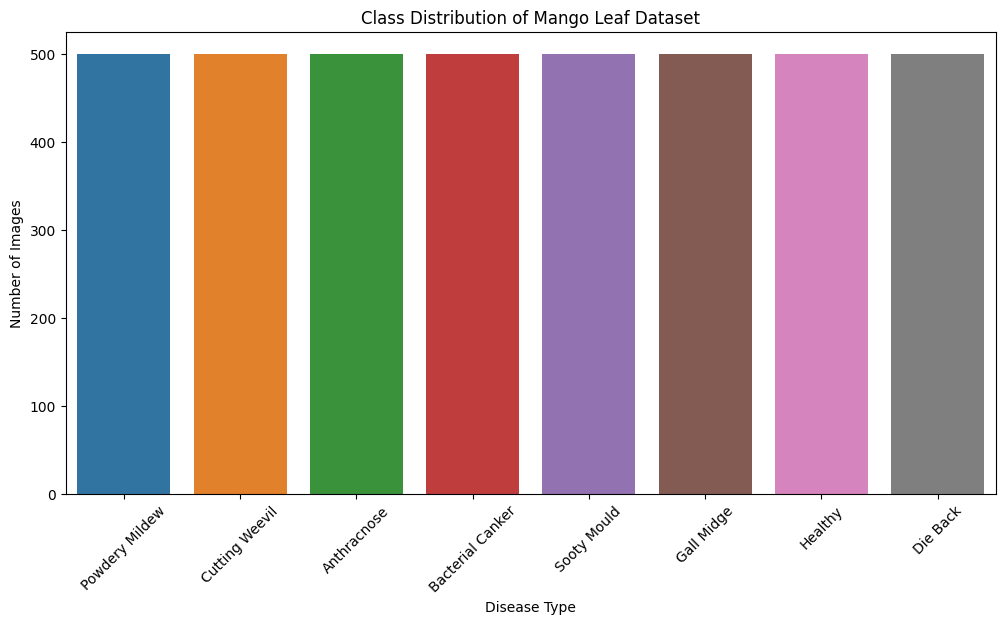

In [4]:
# EDA: Check class distribution
class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), order=list(class_counts.keys()))
plt.xticks(rotation=45)
plt.title("Class Distribution of Mango Leaf Dataset")
plt.xlabel("Disease Type")
plt.ylabel("Number of Images")
plt.savefig("/kaggle/working/class_distribution.png")
plt.show()

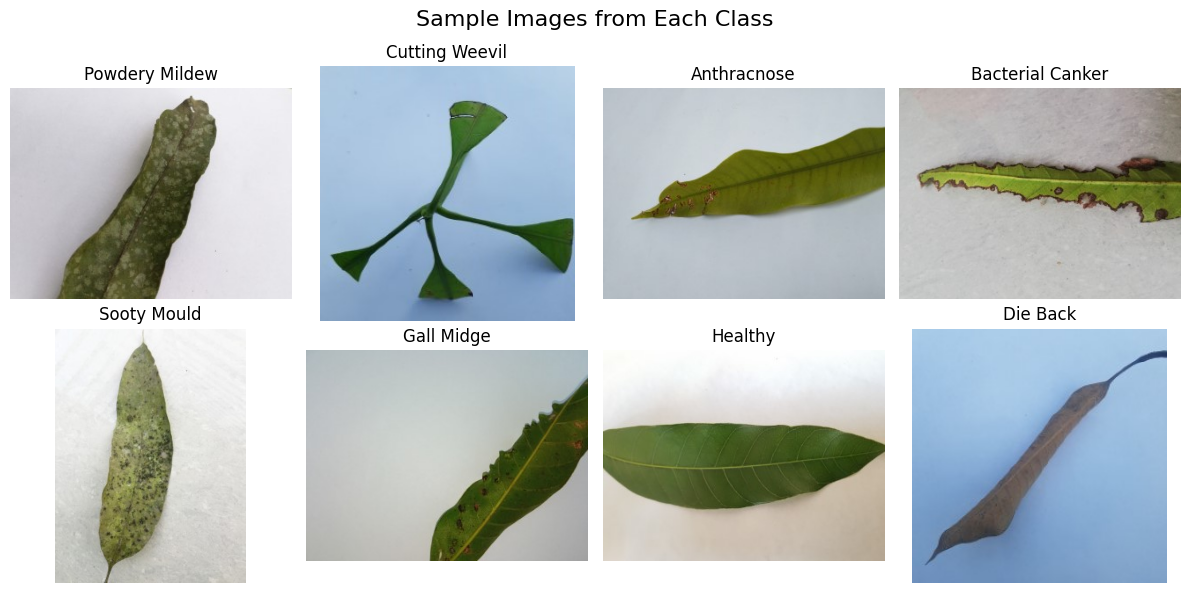

In [5]:
# Display sample images per class
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Sample Images from Each Class", fontsize=16)
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    image_file = glob(os.path.join(class_path, "*.jpg"))[0]  # Select the first image
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i // 4, i % 4].imshow(img)
    axes[i // 4, i % 4].set_title(class_name)
    axes[i // 4, i % 4].axis("off")
plt.tight_layout()
plt.savefig("/kaggle/working/sample_images.png")
plt.show()

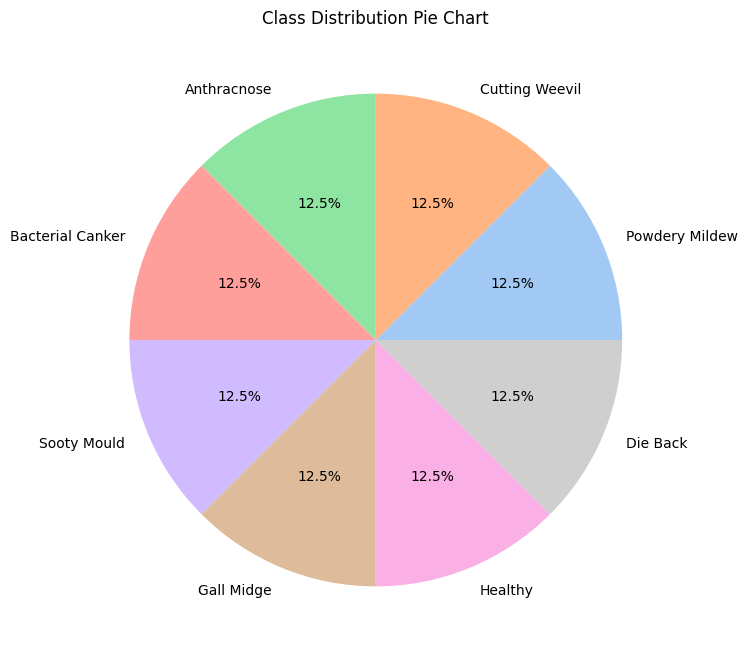

In [6]:
# Pie Chart for Class Distribution
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Class Distribution Pie Chart")
plt.savefig("/kaggle/working/class_distribution_pie.png")
plt.show()

In [7]:
# Load dataset and preprocess images
def load_dataset(img_size=(100, 100)):
    X, y = [], []
    image_paths = []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        image_files = glob(os.path.join(class_path, "*.jpg"))
        for img_file in tqdm(image_files, desc=f"Processing {class_name}"):
            img = cv2.imread(img_file)
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(label)
            image_paths.append(img_file)
    return np.array(X), np.array(y), image_paths

In [8]:
# Load and preprocess data
X, y, image_paths = load_dataset()
X = X / 255.0  # Normalize pixel values
X_flat = X.reshape(X.shape[0], -1)  # Flatten for Random Forest and Decision Tree

Processing Die Back: 100%|██████████| 500/500 [00:02<00:00, 188.87it/s]


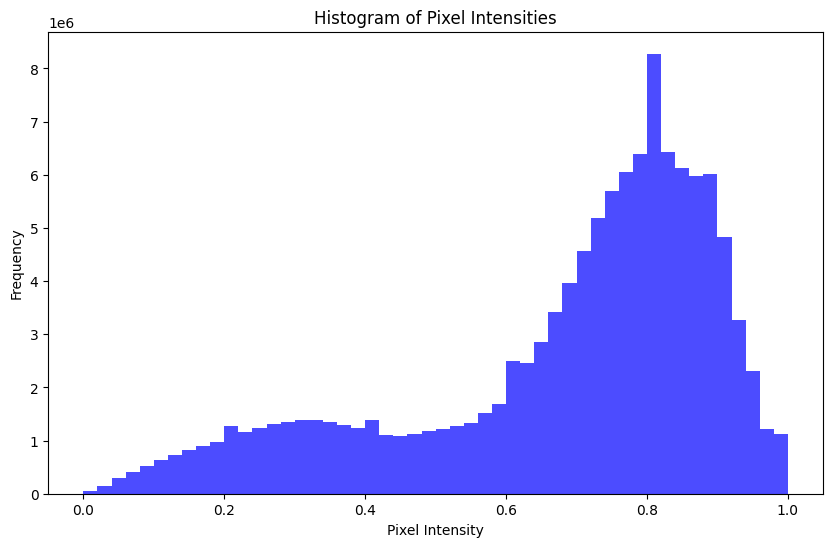

In [9]:
# Histogram of Pixel Intensities
plt.figure(figsize=(10, 6))
plt.hist(X.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Pixel Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.savefig("/kaggle/working/pixel_histogram.png")
plt.show()

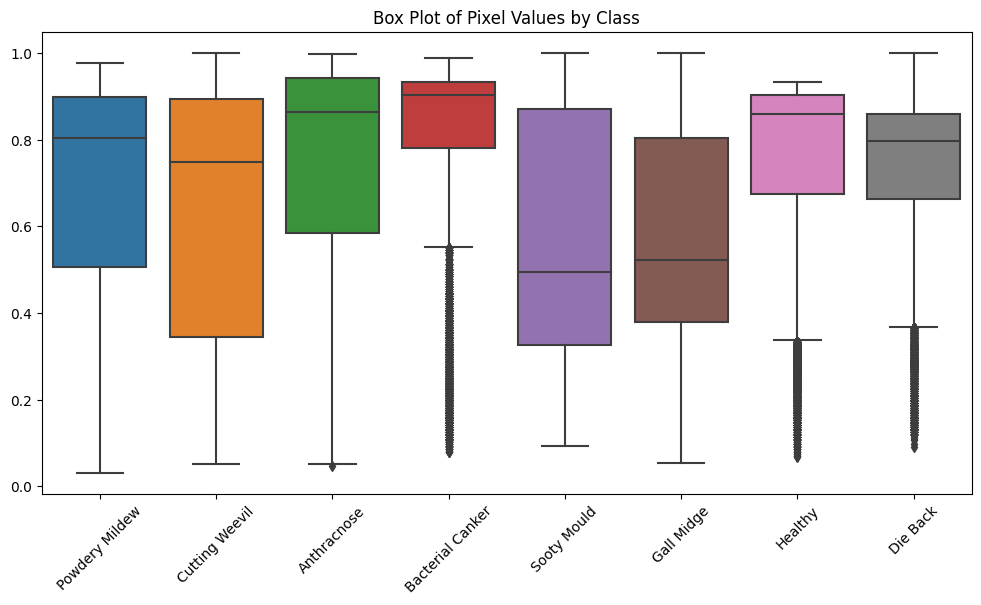

In [10]:
# Box Plot for Pixel Value Distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=[X[i].flatten() for i in range(len(classes))])
plt.xticks(range(len(classes)), classes, rotation=45)
plt.title("Box Plot of Pixel Values by Class")
plt.savefig("/kaggle/working/pixel_boxplot.png")
plt.show()

In [11]:
# Harmonic Mean Calculation
harmonic_mean = len(classes) / sum(1 / count for count in class_counts.values())
print(f"Harmonic Mean of Class Distribution: {harmonic_mean}")

Harmonic Mean of Class Distribution: 500.0


In [12]:
# Load dataset and preprocess images
def load_dataset(img_size=(100, 100)):
    X, y = [], []
    image_paths = []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        image_files = glob(os.path.join(class_path, "*.jpg"))
        for img_file in tqdm(image_files, desc=f"Processing {class_name}"):
            img = cv2.imread(img_file)
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(label)
            image_paths.append(img_file)
    return np.array(X), np.array(y), image_paths

In [13]:
# Load and preprocess data
X, y, image_paths = load_dataset()
X = X / 255.0  # Normalize pixel values
X_flat = X.reshape(X.shape[0], -1)  # Flatten for Random Forest and Decision Tree

# Split dataset
X_train, X_test, y_train, y_test, train_paths, test_paths = train_test_split(X, y, image_paths, test_size=0.2, random_state=42)
X_train_flat, X_test_flat = train_test_split(X_flat, test_size=0.2, random_state=42)

Processing Die Back: 100%|██████████| 500/500 [00:00<00:00, 741.44it/s]


In [14]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)
rf_pred = rf_model.predict(X_test_flat)
rf_accuracy = accuracy_score(y_test, rf_pred)

In [15]:
# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_flat, y_train)
dt_pred = dt_model.predict(X_test_flat)
dt_accuracy = accuracy_score(y_test, dt_pred)

In [16]:
# Train CNN model
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
cnn_pred_probs = cnn_model.predict(X_test)
cnn_pred = np.argmax(cnn_pred_probs, axis=1)
cnn_accuracy = accuracy_score(y_test, cnn_pred)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.2549 - loss: 1.9815 - val_accuracy: 0.6950 - val_loss: 1.0191
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6511 - loss: 0.9935 - val_accuracy: 0.7075 - val_loss: 0.7612
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7297 - loss: 0.7324 - val_accuracy: 0.8438 - val_loss: 0.4434
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8073 - loss: 0.4922 - val_accuracy: 0.8825 - val_loss: 0.3561
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8498 - loss: 0.4278 - val_accuracy: 0.7638 - val_loss: 0.5595
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8593 - loss: 0.3883 - val_accuracy: 0.8650 - val_loss: 0.3489
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8922 - loss: 0.3138 - val_accuracy: 0.9125 - val_loss: 0.2696
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8966 - loss: 0.2651 - val_accuracy: 0

In [17]:
# Save and compare results
report_content = f"""
Exploratory Data Analysis:
Class Distribution: {class_counts}

Model Performance:
Random Forest Accuracy: {rf_accuracy}
Classification Report (Random Forest):
{classification_report(y_test, rf_pred)}

Decision Tree Accuracy: {dt_accuracy}
Classification Report (Decision Tree):
{classification_report(y_test, dt_pred)}

CNN Accuracy: {cnn_accuracy}
Classification Report (CNN):
{classification_report(y_test, cnn_pred)}
"""
with open("/kaggle/working/mango_leaf_classification_report.txt", "w") as f:
    f.write(report_content)

print("Report saved as /kaggle/working/mango_leaf_classification_report.txt")

Report saved as /kaggle/working/mango_leaf_classification_report.txt


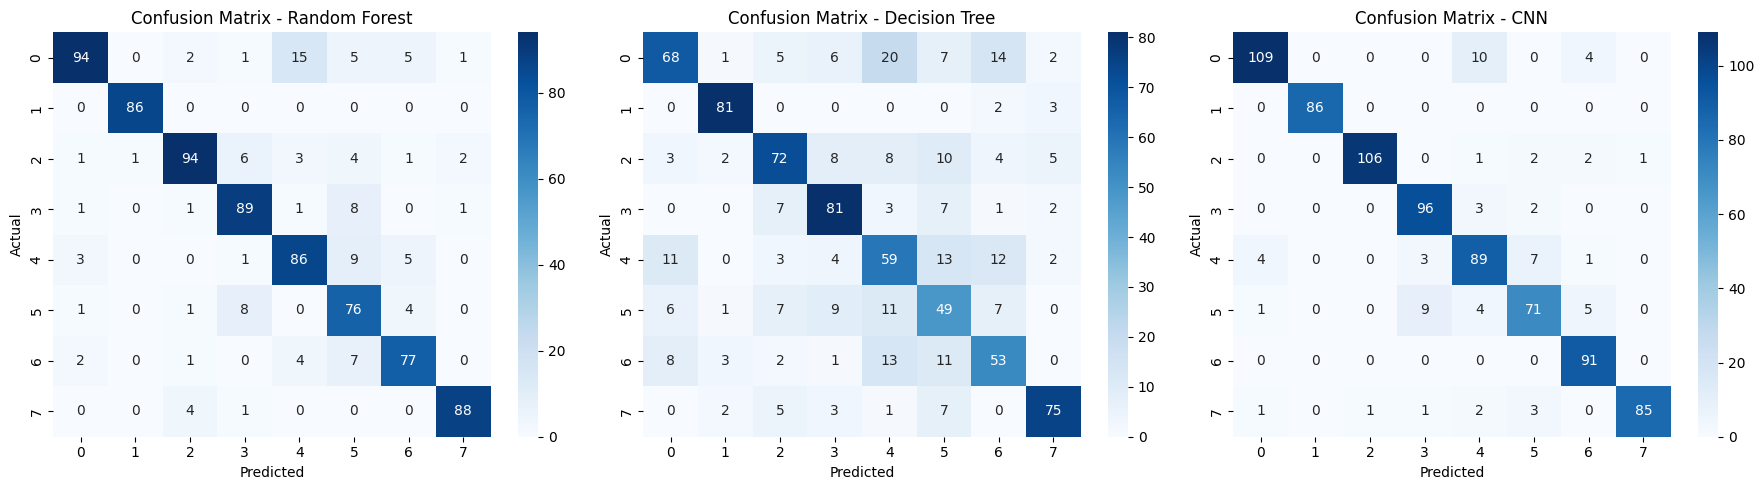

In [18]:
# Confusion Matrices
plt.figure(figsize=(18, 5))  # Adjusted figure size for three plots

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.savefig("/kaggle/working/confusion_matrix_RF.png")

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test, dt_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.savefig("/kaggle/working/confusion_matrix_DT.png")

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test, cnn_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN")
plt.savefig("/kaggle/working/confusion_matrix_CNN.png")

plt.tight_layout()
plt.show()

In [19]:
# Testing function
def predict_image(img_path, model, is_cnn=False):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    if is_cnn:
        img = np.expand_dims(img, axis=0) # Reshape for CNN
        prediction_probs = model.predict(img)
        prediction = np.argmax(prediction_probs, axis=1)
    else:
        img = img.reshape(1, -1)  # Flatten for RF and DT
        prediction = model.predict(img)
    return classes[prediction[0]]

In [20]:
# Test with selected 12 images
test_images = test_paths[:12]  # Select first 12 images from test set
for img_path in test_images:
    rf_prediction = predict_image(img_path, rf_model)
    dt_prediction = predict_image(img_path, dt_model)
    cnn_prediction = predict_image(img_path, cnn_model, is_cnn=True)
    print(f"Image: {img_path}")
    print(f"Random Forest Prediction: {rf_prediction}")
    print(f"Decision Tree Prediction: {dt_prediction}")
    print(f"CNN Prediction: {cnn_prediction}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
Image: /kaggle/input/mangoleaf/MangoLeafBD Dataset/Cutting Weevil/20211011_170254 (Custom) (Custom).jpg
Random Forest Prediction: Cutting Weevil
Decision Tree Prediction: Cutting Weevil
CNN Prediction: Cutting Weevil

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: /kaggle/input/mangoleaf/MangoLeafBD Dataset/Healthy/20211231_162439 (Custom).jpg
Random Forest Prediction: Sooty Mould
Decision Tree Prediction: Gall Midge
CNN Prediction: Healthy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: /kaggle/input/mangoleaf/MangoLeafBD Dataset/Cutting Weevil/20211011_162428 (Custom) (Custom).jpg
Random Forest Prediction: Cutting Weevil
Decision Tree Prediction: Cutting Weevil
CNN Prediction: Cutting Weevil

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: /kaggle/input/mangoleaf/MangoLeafBD Dataset/Die Back/20211129_160920 (Custom).jpg
Random Forest Prediction: Die Back
Decision Tree Prediction: Die Back
CNN Prediction: Die Back

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


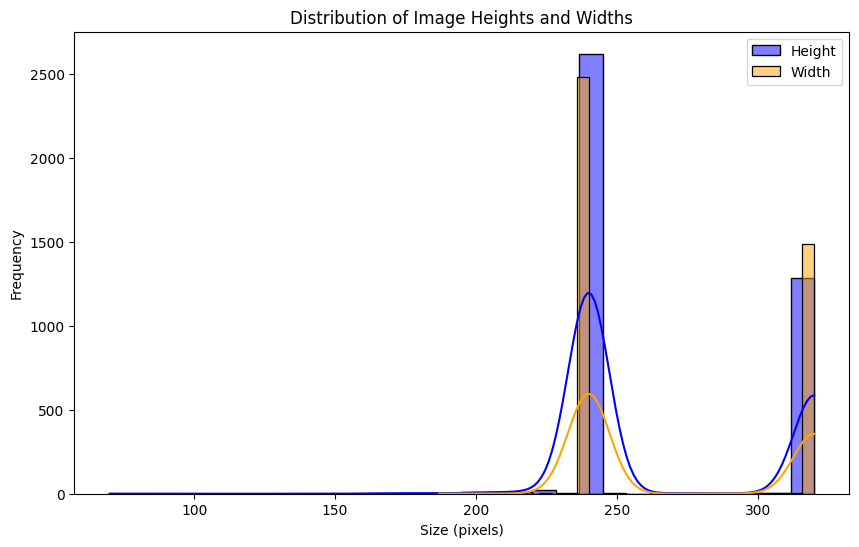

In [21]:
def summarize_image_sizes(dataset_path, classes):
    image_sizes = []
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        image_files = glob(os.path.join(class_path, "*.jpg"))
        for img_file in image_files:
            img = cv2.imread(img_file)
            height, width, _ = img.shape
            image_sizes.append((height, width))
    return pd.DataFrame(image_sizes, columns=["Height", "Width"])

image_sizes_df = summarize_image_sizes(dataset_path, classes)

plt.figure(figsize=(10, 6))
sns.histplot(image_sizes_df["Height"], kde=True, bins=30, label='Height', color='blue')
sns.histplot(image_sizes_df["Width"], kde=True, bins=30, label='Width', color='orange')
plt.legend()
plt.title("Distribution of Image Heights and Widths")
plt.xlabel("Size (pixels)")
plt.ylabel("Frequency")
plt.savefig("/kaggle/working/image_size_distribution.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

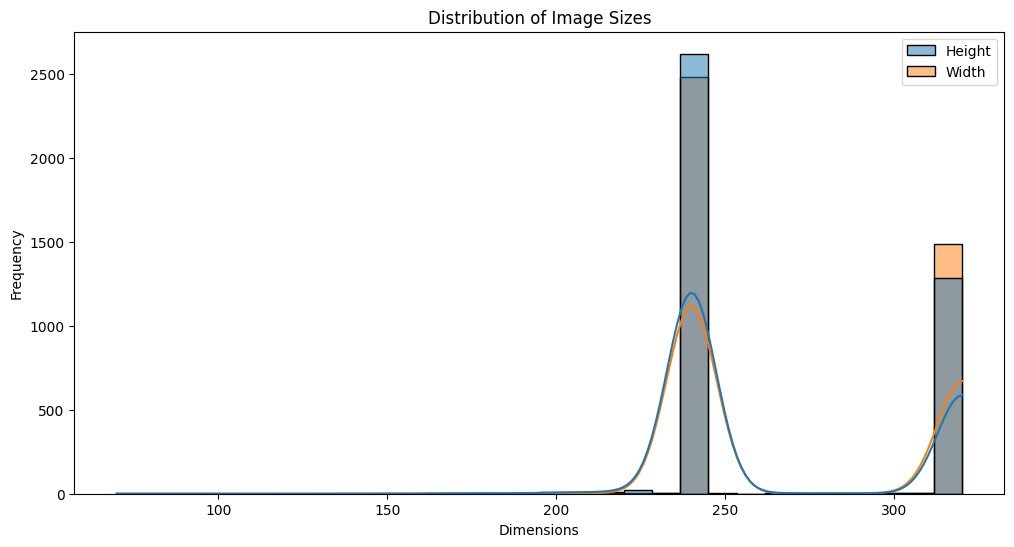

In [22]:
image_sizes = []
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_files = glob(os.path.join(class_path, "*.jpg"))
    for img_file in image_files:
        img = cv2.imread(img_file)
        image_sizes.append(img.shape[:2])

image_sizes_df = pd.DataFrame(image_sizes, columns=["Height", "Width"])
plt.figure(figsize=(12, 6))
sns.histplot(image_sizes_df, bins=30, kde=True)
plt.title("Distribution of Image Sizes")
plt.xlabel("Dimensions")
plt.ylabel("Frequency")
plt.show()

In [23]:
# Random Forest Accuracy
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

# Decision Tree Accuracy
dt_accuracy = accuracy_score(y_test, dt_pred)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")

# CNN Model Accuracy
cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"CNN Model Accuracy: {cnn_accuracy:.2f}")

Random Forest Accuracy: 0.86
Decision Tree Accuracy: 0.67
CNN Model Accuracy: 0.92


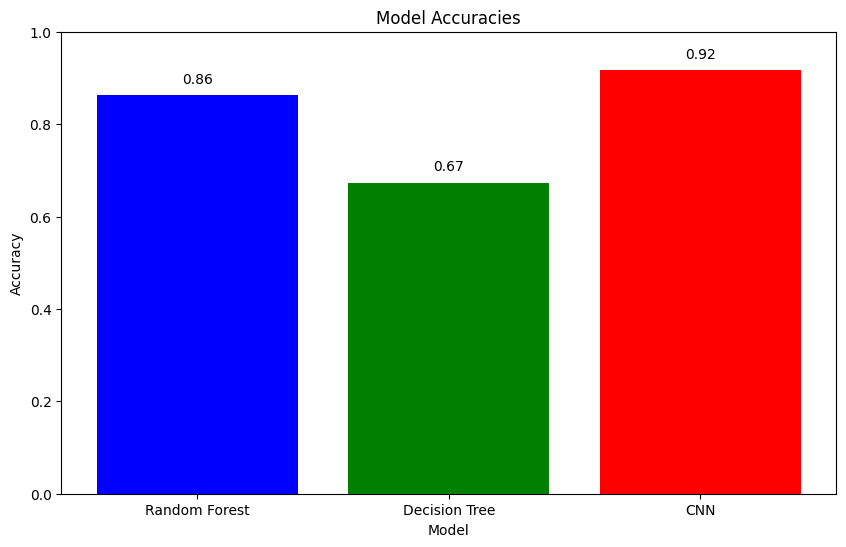

In [24]:
import matplotlib.pyplot as plt

# Model accuracies
model_names = ["Random Forest", "Decision Tree", "CNN"]
model_accuracies = [rf_accuracy, dt_accuracy, cnn_accuracy]

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.title("Model Accuracies")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.text(0, rf_accuracy + 0.02, f"{rf_accuracy:.2f}", ha='center', va='bottom')
plt.text(1, dt_accuracy + 0.02, f"{dt_accuracy:.2f}", ha='center', va='bottom')
plt.text(2, cnn_accuracy + 0.02, f"{cnn_accuracy:.2f}", ha='center', va='bottom')
plt.savefig("/kaggle/working/model_accuracies.png")
plt.show()